In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import os
from astropy.table import Table
import time
import dictionaries
import params
import debias

In [3]:
import astropy
import astropy.units as u
import numpy as np

In [4]:
import sample
from scipy.stats import binned_statistic

In [5]:
data = Table.read(params.data_file)
output_directory = params.output_directory

if not os.path.isdir(output_directory):
    os.mkdir(output_directory)

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt

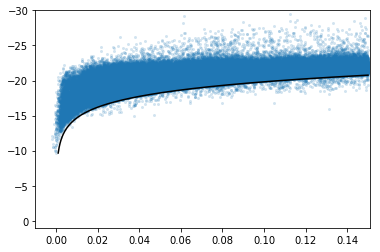

In [7]:
plt.plot(data['z'], data['r_mag'], '.', mec='none', alpha=0.2)
plt.axis(xmin=-0.01, xmax=0.151, ymin=1, ymax=-30)
z = np.linspace(0.001, 0.15, 1000)
C = astropy.cosmology.FlatLambdaCDM(70, 0.3)
r = params.survey_mag_limit * u.mag  - C.distmod(z)
plt.plot(z, r, 'k')

In [8]:
# remove data with dubious mag or size!
data = data[data['r_mag'] < -10]
data = data[data['R_50_kpc'] > 0.1]

In [9]:
question = 't01_smooth_or_features'
answer = 'a02_features_or_disk'

In [10]:
function_dictionary = dictionaries.function_dictionary
questions = dictionaries.questions

data_sample = sample.Sample(data,questions,params,question)
bins = sample.Bins(data_sample,params,questions,question,answer)
bins.voronoi_bin()
bins.voronoi_assignment(reassign=True)
bins.redshift_assignment()

Primary question, so all 297508 galaxies used.
Bin-accretion...
284  initial bins.
Reassign bad bins...
24  good bins.
Modified Lloyd algorithm...
22  iterations.
Unbinned pixels:  0  /  12592
Fractional S/N scatter (%): 14.040592871044533


In [11]:
%aimport fit

In [12]:
# bin by bin...
fv_debiased_bin, v0_tables, vz_tables, dbi_tables, dbf_tables = fit.debias_by_bin(data_sample.all_data,
                                    bins.voronoi_bins,bins.z_bins,
                                    question,answer, return_tables=True)

100%|██████████| 24/24 [01:19<00:00,  3.32s/it]


In [13]:
from matplotlib import cm

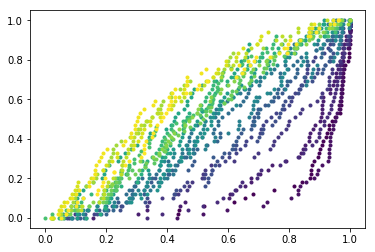

In [14]:
j = 8
for i in range(0, len(vz_tables[j]), 10):
    plt.plot(vz_tables[j][i]['fv'], vz_tables[j][i]['cumfrac'], '.', color=cm.viridis(i))

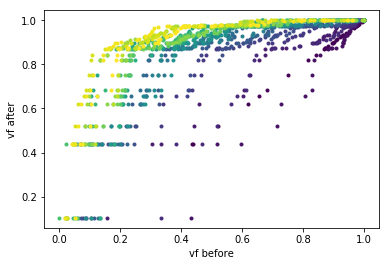

In [15]:
for i in range(0, len(vz_tables[j]), 10):
    plt.plot(vz_tables[j][i]['fv'], dbf_tables[j][i], '.', color=cm.viridis(i))
plt.xlabel('vf before')
plt.ylabel('vf after');

In [ ]:
functionfit, function_, bounds = fit.fit_bins(data_sample,bins,
                                              function_dictionary,params,
                                              question,answer,
                                              verbose=True)
# function fitter...
fitted_k = fit.FitToBins(functionfit,'k',
                  params.clip_percentile).get_kc_function(verbose=True)
fitted_c = fit.FitToBins(functionfit,'c',
                  params.clip_percentile).get_kc_function(verbose=True)
fv, fv_debiased = fit.debias_data(data_sample.all_data,params,
                                  fitted_k,fitted_c,function_,
                                  question,answer)
fv_debiased[np.isfinite(fv_debiased) == False] = 0

In [ ]:
# now need to check which is better -- need a volume limited sample...
in_vl = data_sample.volume_limited_sample()
z = data_sample.all_data[params.z_column]
chi2_bin = debias.get_chi2(fv_debiased_bin[in_vl],fv[in_vl],z[in_vl])
chi2_fit = debias.get_chi2(fv_debiased[in_vl],fv[in_vl],z[in_vl])

if chi2_bin < chi2_fit:
    print('bin method preferred')
    fv_debiased_final = fv_debiased_bin
else:
    print('fit method preferred')
    fv_debiased_final = fv_debiased
print('---------')
print('chi2 (bin) = {}'.format(np.round(chi2_bin,2)))
print('chi2 (fit) = {}'.format(np.round(chi2_fit,2)))
print('---------')

In [ ]:
fv_column = question + '_' + answer + params.fraction_suffix
fv = data[fv_column]

In [ ]:
plt.scatter(fv, fv_debiased, marker='.', alpha=0.1, c=data['z'])
plt.plot(fv[bins.voronoi_bins == j], fv_debiased[bins.voronoi_bins == j], '.', mec='none', alpha=0.1, color='orange')
plt.plot([0, 1], [0, 1])
plt.xlabel('fv_before')
plt.ylabel('fv_debiased_fit')
plt.colorbar(alpha=1);

In [ ]:
plt.scatter(fv, fv_debiased_bin, marker='.', alpha=0.1, c=data['z'])
plt.plot(fv[bins.voronoi_bins == j], fv_debiased_bin[bins.voronoi_bins == j], '.', mec='none', alpha=0.1, color='orange')
plt.xlabel('fv_before')
plt.ylabel('fv_debiased_bin')
plt.plot([0, 1], [0, 1]);